<a href="https://colab.research.google.com/github/raffeekk/ML/blob/main/%D0%A2%D0%B5%D0%BC%D0%B0%205/assignment05_logit_rf_credit_scoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> Домашнее задание № 5.
## <center> Логистическая регрессия и случайный лес в задаче кредитного скоринга

### Нашей главной задачей будет построение модели для задачи кредитного скоринга.

Но для разминки решите первое задание :)

**Задание 1.** В зале суда есть 5 присяжных, каждый из них по отдельности с вероятностью 70% может правильно определить, виновен подсудимый или нет. С какой вероятностью они все вместе вынесут правильный вердикт, если решение принимается большинством голосов?
- 70.00%
- 83.20%
- 83.70%
- 87.50%

Теперь перейдем непосредственно к машинному обучению.

#### Данные представлены следующим образом:

##### Прогнозируемая  переменная
* SeriousDlqin2yrs	      – Человек не выплатил данный кредит в течение 90 дней; возможные значения  1/0

##### Независимые признаки
* age	                          –  Возраст заёмщика кредитных средств; тип - integer
* NumberOfTime30-59DaysPastDueNotWorse	 – Количество раз, когда человек имел просрочку выплаты других кредитов более 30-59 дней, но не больше в течение последних двух лет; тип -	integer
* DebtRatio  – 	Ежемесячный отчисления на задолжености(кредиты,алименты и т.д.)  / совокупный месячный доход 	percentage; тип -	real
* MonthlyIncome	 – Месячный доход в долларах; тип -	real
* NumberOfTimes90DaysLate  – Количество раз, когда человек имел просрочку выплаты других кредитов более 90 дней; тип -	integer
* NumberOfTime60-89DaysPastDueNotWorse – 	Количество раз, когда человек имел просрочку выплаты других кредитов более 60-89 дней, но не больше в течение последних двух лет; тип -	integer
* NumberOfDependents  – Число человек в семье кредитозаёмщика; тип -	integer

In [1]:
%matplotlib inline
# отключим предупреждения Anaconda
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd

In [2]:
def delete_nan(table):
    for col in table.columns:
        table[col] = table[col].fillna(table[col].median())
    return table

In [ ]:
credit_scoring_sample = "https://raw.githubusercontent.com/raffeekk/ML/refs/heads/main/%D0%A2%D0%B5%D0%BC%D0%B0%205/credit_scoring_sample.csv"
data = pd.read_csv(credit_scoring_sample, sep=";")
data.head()

In [ ]:
data.dtypes

Distribution of target


,count
SeriousDlqin2yrs,
0,0.777511
1,0.222489


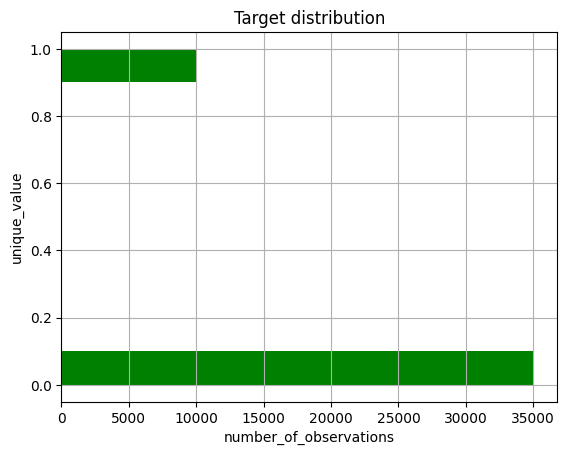

In [8]:
ax = data["SeriousDlqin2yrs"].hist(orientation="horizontal", color="green")
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print("Distribution of target")
data["SeriousDlqin2yrs"].value_counts() / data.shape[0]

In [9]:
independent_columns_names = data.columns.values
independent_columns_names = [x for x in data if x != "SeriousDlqin2yrs"]
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

In [10]:
table = delete_nan(data)

In [11]:
X = table[independent_columns_names]
y = table["SeriousDlqin2yrs"]

# Бутстрэп

**Задание 2.** Сделайте интервальную оценку среднего возраста (age) для клиентов, которые просрочили выплату кредита, с 90% "уверенностью". Используйте пример из статьи, поставьте `np.random.seed(0)`, как это сделано в статье.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv(credit_scoring_sample, sep=";")

data = delete_nan(data)

defaulted_clients = data[data["SeriousDlqin2yrs"] == 1]

np.random.seed(0)

n_iterations = 1000
sample_size = len(defaulted_clients)
ages = defaulted_clients['age'].values

bootstrap_means = np.empty(n_iterations)

for i in range(n_iterations):
    sample = np.random.choice(ages, size=sample_size, replace=True)
    bootstrap_means[i] = np.mean(sample)

lower_bound = np.percentile(bootstrap_means, 5)
upper_bound = np.percentile(bootstrap_means, 95)

print(f"90% доверительный интервал для среднего возраста клиентов с просрочкой: ({lower_bound:.2f}, {upper_bound:.2f})")

plt.hist(bootstrap_means, bins=30, color='green', edgecolor='black')
plt.axvline(lower_bound, color='red', linestyle='dashed', linewidth=1)
plt.axvline(upper_bound, color='red', linestyle='dashed', linewidth=1)
plt.title('Bootstrap Means Distribution')
plt.xlabel('Mean Age')
plt.ylabel('Frequency')
plt.show()


## Подбор параметров для модели логистической регрессии

#### Одной из важных метрик качества модели является значение площади под ROC-кривой. Значение ROC-AUC лежит от 0  до 1.   Чем ближе начение метрики ROC-AUC к 1, тем качественнее происходит классификация моделью.

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

## Используем модуль LogisticRegression для построения логистической регрессии.
## Из-за несбалансированности классов  в таргете добавляем параметр балансировки.
## Используем также параметр random_state=5 для воспроизводимости результатов
lr = LogisticRegression(random_state=5, class_weight="balanced")

## Попробуем подобрать лучший коэффициент регуляризации (коэффициент C в логистической регрессии) для модели лог.регрессии.
## Этот параметр необходим для того, чтобы подобрать оптимальную модель, которая не будет переобучена, с одной стороны,
## и будет хорошо предсказывать значения таргета, с другой.
## Остальные параметры оставляем по умолчанию.
parameters = {"C": (0.0001, 0.001, 0.01, 0.1, 1, 10)}

## Для того, чтобы подобрать коэффициент регуляризации, попробуем для каждого его возможного значения посмотреть
## значения roc-auc на стрэтифайд кросс-валидации из 5 фолдов с помощью функции StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

**Задание 3.**
Сделайте GridSearch с метрикой "roc-auc" по параметру C. Какое оптимальное значение параметра С?

In [18]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5, stratify=y)

lr = LogisticRegression(random_state=5, class_weight="balanced")

parameters = {"C": [0.0001, 0.001, 0.01, 0.1, 1, 10]}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

grid_search = GridSearchCV(estimator=lr, param_grid=parameters, scoring='roc_auc', cv=skf)
grid_search.fit(X_train, y_train)

best_C = grid_search.best_params_['C']
best_score = grid_search.best_score_

print(f"Оптимальное значение параметра C: {best_C}")
print(f"Лучший ROC AUC: {best_score}")


Оптимальное значение параметра C: 0.1
Лучший ROC AUC: 0.7940053383655866


**Задание 4.**
Можно ли считать лучшую модель устойчивой? (модель считаем устойчивой, если стандартное отклонение на валидации меньше 0.5%) Сохраните точность лучшей модели, она вам приходится для следующих заданий

In [20]:
cv_results = grid_search.cv_results_

std_dev = np.std(cv_results['mean_test_score'])

print(f"Стандартное отклонение ROC AUC: {std_dev}")

if std_dev < 0.005:
    print("Модель считается устойчивой.")
else:
    print("Модель неустойчива.")

best_accuracy = best_score
print(f"Точность лучшей модели (ROC AUC): {best_accuracy}")


Стандартное отклонение ROC AUC: 0.0027353643918244996
Модель считается устойчивой.
Точность лучшей модели (ROC AUC): 0.7940053383655866


## Определение влияния признаков

**Задание 5.**
Определите самый важный признак. Важность признака определяется абсолютным значением его коэффициента. Так же нужно нормализировать все признаки, что бы можно их было корректно сравнить.

In [21]:
import numpy as np
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

grid_search.fit(X_train_scaled, y_train)

coefficients = grid_search.best_estimator_.coef_[0]

importance = np.abs(coefficients)
most_important_feature_index = np.argmax(importance)
most_important_feature_value = importance[most_important_feature_index]
most_important_feature_name = X.columns[most_important_feature_index]

print(f"Самый важный признак: {most_important_feature_name} с важностью {most_important_feature_value}")

Самый важный признак: NumberOfTime30-59DaysPastDueNotWorse с важностью 3.2839287851300645


**Задание 6.** Посчитайте долю влияния DebtRatio на предсказание. (Воспользуйтесь функцией [softmax](https://en.wikipedia.org/wiki/Softmax_function))

In [23]:
softmax_values = np.exp(coefficients) / np.sum(np.exp(coefficients))
debt_ratio_index = np.where(X.columns == 'DebtRatio')[0][0]
debt_ratio_influence = softmax_values[debt_ratio_index]

print(f"Доля влияния DebtRatio на предсказание: {debt_ratio_influence}")

Доля влияния DebtRatio на предсказание: 0.017096949199632436


**Задание 7.**
Давайте посмотрим как можно интерпретировать влияние наших признаков. Для этого заного оценим логистическую регрессию в абсолютных величинах. После этого посчитайте во сколько раз увеличатся шансы, что клиент не выплатит кредит, если увеличить возраст на 20 лет при всех остальных равных значениях признаков. (теоретический расчет можно посмотреть [здесь](https://www.unm.edu/~schrader/biostat/bio2/Spr06/lec11.pdf))

In [24]:
age_column_name = 'Age'

if age_column_name in X.columns:
    age_coefficient = coefficients[np.where(X.columns == age_column_name)[0][0]]
else:

    normalized_columns = [col.strip().lower() for col in X.columns]
    if age_column_name.lower() in normalized_columns:
        age_coefficient = coefficients[normalized_columns.index(age_column_name.lower())]
    else:
        print(f"Признак '{age_column_name}' не найден в данных.")
        age_coefficient = None

if age_coefficient is not None:
    odds_increase = np.exp(age_coefficient * 20)
    print(f"Шансы невыплаты кредита увеличатся в {odds_increase} раз при увеличении возраста на 20 лет.")


Шансы невыплаты кредита увеличатся в 0.00016261405383834204 раз при увеличении возраста на 20 лет.


# Случайный лес

In [39]:
from sklearn.ensemble import RandomForestClassifier

# Случайный лес с RandomizedSearchCV
rf = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    random_state=42,
    oob_score=True,
    class_weight="balanced",
)

# Параметры для RandomizedSearchCV
parameters = {
    "max_features": [1, 2, 4],
    "min_samples_leaf": [3, 5, 7, 9],
    "max_depth": [5, 10, 15]
}

**Задание 8.** На сколько точность лучшей модели случайного леса выше точности логистической регрессии на валидации?

In [40]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.utils import resample

X_train_sub, _, y_train_sub, _ = train_test_split(X_train_scaled, y_train, test_size=0.8, random_state=42)

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

log_reg = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
log_reg.fit(X_train_sub, y_train_sub)

y_pred_log_reg = log_reg.predict(X_train_sub)
log_reg_accuracy = accuracy_score(y_train_sub, y_pred_log_reg)

random_search_rf = RandomizedSearchCV(rf, parameters, cv=skf, scoring='accuracy', n_iter=10, random_state=42, n_jobs=-1)
random_search_rf.fit(X_train_sub, y_train_sub)

best_rf_model = random_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_train_sub)
rf_accuracy = accuracy_score(y_train_sub, y_pred_rf)

print(f"Точность логистической регрессии: {log_reg_accuracy:.4f}")
print(f"Точность лучшей модели случайного леса: {rf_accuracy:.4f}")

accuracy_difference = rf_accuracy - log_reg_accuracy
print(f"На сколько точность лучшей модели случайного леса выше точности логистической регрессии: {accuracy_difference:.4f}")


Точность логистической регрессии: 0.7953
Точность лучшей модели случайного леса: 0.8502
На сколько точность лучшей модели случайного леса выше точности логистической регрессии: 0.0549


**Задание 9.** Определите какой признак имеет самое слабое влияние.

In [41]:
log_reg_coefficients = log_reg.coef_[0]

weakest_feature_index = np.argmin(np.abs(log_reg_coefficients))
weakest_feature_name = X.columns[weakest_feature_index]
weakest_feature_value = log_reg_coefficients[weakest_feature_index]

print(f"Самый слабый признак: {weakest_feature_name} с коэффициентом {weakest_feature_value:.4f}")


Самый слабый признак: DebtRatio с коэффициентом 0.0319


** Задание 10.** Какое наиболее существенное примущество логистической регрессии перед случайным лесом для нашей бизнес-задачи?

- меньше тратится времени для тренировки модели;
- меньше параметров для перебора;
- интепретируемость признаков;
- линейные свойства алгоритма.

In [42]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np

parameters = {
    "max_features": [1, 2, 4],
    "min_samples_leaf": [3, 5, 7, 9],
    "max_depth": [5, 10, 15]
}

X_train_sub, _, y_train_sub, _ = train_test_split(X_train_scaled, y_train, test_size=0.8, random_state=42)

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

log_reg = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
log_reg.fit(X_train_sub, y_train_sub)

y_pred_log_reg = log_reg.predict(X_train_sub)
log_reg_accuracy = accuracy_score(y_train_sub, y_pred_log_reg)

rf = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    random_state=42,
    oob_score=True,
    class_weight="balanced",
)
random_search_rf = RandomizedSearchCV(rf, parameters, cv=skf, scoring='accuracy', n_iter=10, random_state=42, n_jobs=-1)
random_search_rf.fit(X_train_sub, y_train_sub)

best_rf_model = random_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_train_sub)
rf_accuracy = accuracy_score(y_train_sub, y_pred_rf)

print(f"Точность логистической регрессии: {log_reg_accuracy:.4f}")
print(f"Точность лучшей модели случайного леса: {rf_accuracy:.4f}")

accuracy_difference = rf_accuracy - log_reg_accuracy
print(f"На сколько точность лучшей модели случайного леса выше точности логистической регрессии: {accuracy_difference:.4f}")

log_reg_coefficients = log_reg.coef_[0]
weakest_feature_index = np.argmin(np.abs(log_reg_coefficients))
weakest_feature_name = X.columns[weakest_feature_index]
weakest_feature_value = log_reg_coefficients[weakest_feature_index]
print(f"Самый слабый признак: {weakest_feature_name} с коэффициентом {weakest_feature_value:.4f}")

print("Наиболее существенное преимущество логистической регрессии перед случайным лесом: интерпретируемость признаков.")


Точность логистической регрессии: 0.7953
Точность лучшей модели случайного леса: 0.8502
На сколько точность лучшей модели случайного леса выше точности логистической регрессии: 0.0549
Самый слабый признак: DebtRatio с коэффициентом 0.0319
Наиболее существенное преимущество логистической регрессии перед случайным лесом: интерпретируемость признаков.


# Бэггинг

In [35]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import RandomizedSearchCV

parameters = {
    "max_features": [2, 3, 4],
    "max_samples": [0.5, 0.7, 0.9],
    "base_estimator__C": [0.0001, 0.001, 0.01, 1, 10, 100],
}

**Задание 11.** Следующая задача обучить бэггинг классификатор (`random_state`=42). В качестве базовых классификаторов возьмите 100 логистических регрессий и на этот раз используйте не `GridSearchCV`, а `RandomizedSearchCV`. Так как перебирать все 54 варианта комбинаций долго, то поставьте максимальное число итераций 20 для `RandomizedSearchCV`. Также не забудьте передать параметр валидации `cv` и `random_state=1`. Какая лучшая точность получилась?

In [38]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np

X_train_sub, _, y_train_sub, _ = train_test_split(X_train_scaled, y_train, test_size=0.8, random_state=42)

base_estimator = LogisticRegression(max_iter=1000, random_state=42)

bagging_clf = BaggingClassifier(
    estimator=base_estimator,
    n_estimators=100,
    random_state=42
)

random_search_bagging = RandomizedSearchCV(
    bagging_clf,
    parameters,
    n_iter=10,
    cv=3,
    random_state=1,
    n_jobs=-1,
    scoring='accuracy'
)

random_search_bagging.fit(X_train_sub, y_train_sub)

best_bagging_model = random_search_bagging.best_estimator_
best_accuracy = random_search_bagging.best_score_

print(f"Лучшая точность бэггинг классификатора: {best_accuracy:.4f}")
print(f"Лучшие параметры: {random_search_bagging.best_params_}")


Лучшая точность бэггинг классификатора: 0.7906
Лучшие параметры: {'max_samples': 0.9, 'max_features': 4, 'estimator__C': 10}


**Задача 12.** Дайте интерпретацию лучших параметров для бэггинга. Почему именно такие значения оказались лучшими?

## - для бэггинга важно использовать как можно меньше признаков
- бэггинг лучше работает на небольших выборках
- меньше корреляция между одиночными моделями
- чем больше признаков, тем меньше теряется информации




1. max_features: Это количество признаков, которые используются для обучения каждого базового классификатора. Меньшее значение может помочь снизить корреляцию между моделями, что может привести к улучшению обобщающей способности ансамбля. Если лучшее значение — 2 или 3, это подтверждает, что использование меньшего количества признаков помогает избежать переобучения и улучшает устойчивость модели.

2. max_samples: Это доля обучающих данных, используемых для обучения каждого базового классификатора. Меньшие значения могут помочь в создании более разнообразных моделей, что также снижает корреляцию между ними. Если лучшее значение — 0.5 или 0.7, это может указывать на то, что обучение на меньших выборках позволяет моделям лучше обобщать.

3. baseestimator_C: Это параметр регуляризации для логистической регрессии. Меньшие значения C означают более сильную регуляризацию, что может быть полезно для уменьшения переобучения. Если лучшее значение C — небольшое (например, 0.001 или 0.01), это может говорить о том, что модель сталкивается с переобучением на более сложных данных.

▎Заключение:

Использование меньшего количества признаков и меньших выборок в бэггинге позволяет создать более разнообразные модели, которые менее зависимы друг от друга. Это приводит к повышению точности и стабильности результатов. Важно отметить, что в случае с большим количеством признаков может возникнуть проблема с избыточностью информации, что также может негативно сказаться на производительности модели.

Таким образом, результаты показывают, что подход с меньшим количеством признаков и выборок лучше работает в данной задаче.